#### Notebook destinado ao projeto final da disciplina

**Universidade Federal do Rio de Janeiro**

**COPPE | Mestrado | PEE**

**Autor**: Matheus Ferreira do Espírito Santo

**Professora**: Rosa Maria Meri Leão

**Disciplina**: COS868 - Probabilidade e estatística para Aprendizado de Máquina


## Bibliotecas

In [1]:
import pandas as pd
import numpy as np

import scipy as sp
from scipy.stats import gamma, norm, chi2_contingency
from scipy.optimize import minimize

import statsmodels.api as sm
from statsmodels.graphics import gofplots

import matplotlib.pyplot as plt
import seaborn as sns

## Dados

Os dados representam a taxa de dados enviados em bps (taxa de upload) e a taxa de dados recebidos em bps (taxa de download) de/por um dispositivo na casa de um usuário do provedor.

Cada arquivo possui os seguintes campos: **device_id**, **date_hour**,
**bytes_up** e **bytes_down**.

* O campo **device_id** é o identificador único do dispositivo que
está na casa de um usuário do provedor.
* O campo **date_hour** é a data e a hora em que a coleta de dados foi realizada com a granularidade de 1 minuto.
* Os campos **bytes_up** e **bytes_down** contém, respectivamente, as taxas em bps dos dados enviados (taxa de upload) e dos dados recebidos (taxa de download) pelo dispositivo em um minuto.

### Caminho dos dados

In [2]:
dt_chromecast_path = "/content/drive/MyDrive/Colab Notebooks/EstatisticaML/dataset_chromecast.csv"
dt_smartv_path = "/content/drive/MyDrive/Colab Notebooks/EstatisticaML/dataset_smart-tv.csv"

### Carregando os dados

In [3]:
df_chromecast = pd.read_csv(dt_chromecast_path)
df_smart = pd.read_csv(dt_smartv_path)

### Visualizando amostra dos dados

In [4]:
df_chromecast.head()

,device_id,date_hour,bytes_up,bytes_down
0,66161985,2021-09-06 00:01:00,2987.016393,49185.704918
1,66161985,2021-09-06 00:02:00,685.935484,328.258065
2,66161985,2021-09-06 00:03:00,4493.901639,37914.064516
3,66161985,2021-09-06 00:04:00,776.133333,229.200000
4,66161985,2021-09-06 00:05:00,3081.311475,51656.800000


In [5]:
df_smart.head()

,device_id,date_hour,bytes_up,bytes_down
0,77209603,2021-11-22 15:23:00,132932.983607,2.818140e+06
1,77209603,2021-11-22 15:24:00,115770.491803,2.264410e+06
2,77209603,2021-11-22 15:25:00,114030.032787,2.309270e+06
3,77209603,2021-11-22 15:26:00,97170.622951,2.006544e+06
4,77209603,2021-11-22 15:27:00,39569.573770,8.061440e+05


## Análise inicial simples

### Verificando quantidade de amostras e colunas

In [6]:
print("Chromecast")
print(f"Quantidade de amostras: {df_chromecast.shape[0]}")
print(f"Quantidade de colunas: {df_chromecast.shape[1]}")

print(f"\nSmart TV")
print(f"Quantidade de amostras: {df_smart.shape[0]}")
print(f"Quantidade de colunas: {df_smart.shape[1]}")

Chromecast
Quantidade de amostras: 1620529
Quantidade de colunas: 4

Smart TV
Quantidade de amostras: 4417903
Quantidade de colunas: 4


### Verificando tipo das variáveis

In [7]:
print("Tipo das variáveis no dataset do dispositivo Chromecast: \n")
df_chromecast.dtypes

Tipo das variáveis no dataset do dispositivo Chromecast: 



device_id       int64
date_hour      object
bytes_up      float64
bytes_down    float64
dtype: object

In [8]:
print("Tipo das variáveis no dataset do dispositivo Smart TV: \n")
df_smart.dtypes

Tipo das variáveis no dataset do dispositivo Smart TV: 



device_id       int64
date_hour      object
bytes_up      float64
bytes_down    float64
dtype: object

### Verificando dados nulos

In [9]:
print("Quantidade de valores ausentes/nulos no dataset do dispositivo Chromecast:\n")
df_chromecast.isnull().sum()

Quantidade de valores ausentes/nulos no dataset do dispositivo Chromecast:



device_id     0
date_hour     0
bytes_up      0
bytes_down    0
dtype: int64

In [10]:
print("Quantidade de valores ausentes/nulos no dataset do dispositivo Smart TV:\n")
df_smart.isnull().sum()

Quantidade de valores ausentes/nulos no dataset do dispositivo Smart TV:



device_id     0
date_hour     0
bytes_up      0
bytes_down    0
dtype: int64

> Não há valores nulos nos dois conjuntos de dados para serem tratados.

### Verificando quantidade de valores zerados

In [11]:
def verificar_zeros(dataframe, nome_disp: str, nome_coluna_upload: str = "bytes_up", nome_coluna_download: str = "bytes_down"):
  nzero_tx_up = dataframe[dataframe[nome_coluna_upload] == 0.0].shape[0]
  nzero_tx_dw = dataframe[dataframe[nome_coluna_download] == 0.0].shape[0]
  df_tam = dataframe.shape[0]

  print(f"Quantidade de valores zerados no dataset do dispositivo {nome_disp}:\n")
  print(f"1. Taxa de upload: {nzero_tx_up} | ({round(nzero_tx_up / df_tam * 100, 2)}% do dataset)")
  print(f"2. Taxa de download: {nzero_tx_dw} | ({round(nzero_tx_dw / df_tam * 100, 2)}% do dataset)")

In [12]:
verificar_zeros(dataframe = df_chromecast, nome_disp = "Chromecast")

Quantidade de valores zerados no dataset do dispositivo Chromecast:

1. Taxa de upload: 6057 | (0.37% do dataset)
2. Taxa de download: 4099 | (0.25% do dataset)


In [13]:
verificar_zeros(dataframe = df_smart, nome_disp = "Smart TV")

Quantidade de valores zerados no dataset do dispositivo Smart TV:

1. Taxa de upload: 1803853 | (40.83% do dataset)
2. Taxa de download: 1978337 | (44.78% do dataset)


> O conjunto de dados do dispositivo Smart TV possui um número bastante alto de registros tanto de taxa de upload quanto taxa de download zerados.

### Verificando existência de valores negativos

In [14]:
def verificar_negativos(dataframe, nome_disp: str, nome_coluna_upload: str = "bytes_up", nome_coluna_download: str = "bytes_down"):
  nneg_tx_up = dataframe[dataframe[nome_coluna_upload] < 0.0].shape[0]
  nneg_tx_dw = dataframe[dataframe[nome_coluna_download] < 0.0].shape[0]
  df_tam = dataframe.shape[0]

  print(f"Quantidade de valores negativos no dataset do dispositivo {nome_disp}:\n")
  print(f"1. Taxa de upload: {nneg_tx_up} | ({round(nneg_tx_up / df_tam * 100, 2)}% do dataset)")
  print(f"2. Taxa de download: {nneg_tx_dw} | ({round(nneg_tx_dw / df_tam * 100, 2)}% do dataset)")

In [15]:
verificar_negativos(dataframe = df_chromecast, nome_disp = "Chromecast")

Quantidade de valores negativos no dataset do dispositivo Chromecast:

1. Taxa de upload: 0 | (0.0% do dataset)
2. Taxa de download: 0 | (0.0% do dataset)


In [16]:
verificar_negativos(dataframe = df_smart, nome_disp = "Smart TV")

Quantidade de valores negativos no dataset do dispositivo Smart TV:

1. Taxa de upload: 0 | (0.0% do dataset)
2. Taxa de download: 0 | (0.0% do dataset)


### Verificando período de registros dos datasets

**Chromecast**

In [17]:
temp_ = pd.to_datetime(df_chromecast['date_hour'])
print(f"Menor data registrada: {np.min(temp_.dt.date)}")
print(f"Maior data registrada: {np.max(temp_.dt.date)}")
print(f"Número de dias registrados: {np.max(temp_.dt.date) - np.min(temp_.dt.date)}")

Menor data registrada: 2021-09-06
Maior data registrada: 2021-11-28
Número de dias registrados: 83 days, 0:00:00


**Smart TV**

In [18]:
temp_ = pd.to_datetime(df_smart['date_hour'])
print(f"Menor data registrada: {np.min(temp_.dt.date)}")
print(f"Maior data registrada: {np.max(temp_.dt.date)}")
print(f"Número de dias registrados: {np.max(temp_.dt.date) - np.min(temp_.dt.date)}")

Menor data registrada: 2021-09-06
Maior data registrada: 2021-11-28
Número de dias registrados: 83 days, 0:00:00


## Pré-processamento

**ATIVIDADE PRINCIPAL**

Atenção:

* **Reescalonar dados para log 10**: como os valores das taxas de upload e
de download variam diversas ordens de grandeza, para calcular as estatísticas é necessário reescalonar as taxas para log na base 10.

___________________

### Renomeando as colunas

In [19]:
nomes = {
    "device_id": "id_dispositivo",
    "date_hour": "data_hora",
    "bytes_up": "taxa_upload",
    "bytes_down": "taxa_download"
}

df_chromecast.rename(nomes, axis = 1, inplace = True)
df_smart.rename(nomes, axis = 1, inplace = True);

In [20]:
### Verificando atualização no nome das colunas
print(f"Nome das colunas no dataset do dispositivo Chromecast = {list(df_chromecast.columns)}")
print(f"Nome das colunas no dataset do dispositivo Smart TV = {list(df_smart.columns)}")

Nome das colunas no dataset do dispositivo Chromecast = ['id_dispositivo', 'data_hora', 'taxa_upload', 'taxa_download']
Nome das colunas no dataset do dispositivo Smart TV = ['id_dispositivo', 'data_hora', 'taxa_upload', 'taxa_download']


### Reescalando os dados para log10

In [21]:
### Convertendo dados do dispositivo Chromecast
df_chromecast['log_taxa_upload'] = df_chromecast['taxa_upload'].apply(lambda x: np.log10(x) if x != 0.0 else 0.0)
df_chromecast['log_taxa_download'] = df_chromecast['taxa_download'].apply(lambda x: np.log10(x) if x != 0.0 else 0.0)

In [22]:
df_chromecast.head(2)

,id_dispositivo,data_hora,taxa_upload,taxa_download,log_taxa_upload,log_taxa_download
0,66161985,2021-09-06 00:01:00,2987.016393,49185.704918,3.475238,4.691839
1,66161985,2021-09-06 00:02:00,685.935484,328.258065,2.836283,2.516215


In [23]:
### Convertendo dados do dispositivo Smart TV
df_smart['log_taxa_upload'] = df_smart['taxa_upload'].apply(lambda x: np.log10(x) if x != 0.0 else 0.0)
df_smart['log_taxa_download'] = df_smart['taxa_download'].apply(lambda x: np.log10(x) if x != 0.0 else 0.0)

In [24]:
df_smart.head(2)

,id_dispositivo,data_hora,taxa_upload,taxa_download,log_taxa_upload,log_taxa_download
0,77209603,2021-11-22 15:23:00,132932.983607,2.818140e+06,5.123633,6.449962
1,77209603,2021-11-22 15:24:00,115770.491803,2.264410e+06,5.063598,6.354955


### Verificando se foi mantido a mesma proporção de zeros após reescalonamento

In [25]:
verificar_zeros(dataframe = df_chromecast, nome_disp = "Chromecast", nome_coluna_upload = "log_taxa_upload", nome_coluna_download = "log_taxa_download")

Quantidade de valores zerados no dataset do dispositivo Chromecast:

1. Taxa de upload: 6058 | (0.37% do dataset)
2. Taxa de download: 4099 | (0.25% do dataset)


In [26]:
verificar_zeros(dataframe = df_smart, nome_disp = "Smart TV", nome_coluna_upload = "log_taxa_upload", nome_coluna_download = "log_taxa_download")

Quantidade de valores zerados no dataset do dispositivo Smart TV:

1. Taxa de upload: 1803857 | (40.83% do dataset)
2. Taxa de download: 1978343 | (44.78% do dataset)


> Proporção mantida como esperado. Desse modo, o processo foi realizado corretamente. Mas vale mencionar que a taxa de upload do Chromecast aumentou em 1, as taxas de upload e download da Smart TV aumentaram em 4 e 6 zeros, respectivamente, o que indica a presença de valores iguais a 1 que após a conversão se tornaram 0.

### Separando e formatando colunas de data e hora

In [27]:
### Tratando dados do dispositivo Chromecast
df_chromecast['data'] = pd.to_datetime(df_chromecast['data_hora']).dt.strftime('%d/%m/%Y')
df_chromecast['hora'] = pd.to_datetime(df_chromecast['data_hora']).dt.strftime('%H:%M:%S')

In [28]:
df_chromecast.head(2)

,id_dispositivo,data_hora,taxa_upload,taxa_download,log_taxa_upload,log_taxa_download,data,hora
0,66161985,2021-09-06 00:01:00,2987.016393,49185.704918,3.475238,4.691839,06/09/2021,00:01:00
1,66161985,2021-09-06 00:02:00,685.935484,328.258065,2.836283,2.516215,06/09/2021,00:02:00


In [29]:
### Tratando dados do dispositivo Smart TV
df_smart['data'] = pd.to_datetime(df_smart['data_hora']).dt.strftime('%d/%m/%Y')
df_smart['hora'] = pd.to_datetime(df_smart['data_hora']).dt.strftime('%H:%M:%S')

In [30]:
df_smart.head(2)

,id_dispositivo,data_hora,taxa_upload,taxa_download,log_taxa_upload,log_taxa_download,data,hora
0,77209603,2021-11-22 15:23:00,132932.983607,2.818140e+06,5.123633,6.449962,22/11/2021,15:23:00
1,77209603,2021-11-22 15:24:00,115770.491803,2.264410e+06,5.063598,6.354955,22/11/2021,15:24:00


### Selecionando colunas para demais análises

In [31]:
colunas = ["data", "hora", "log_taxa_upload", "log_taxa_download"]

df_chromecast = df_chromecast[colunas]
df_smart = df_smart[colunas]

In [32]:
df_chromecast.head(1)

,data,hora,log_taxa_upload,log_taxa_download
0,06/09/2021,00:01:00,3.475238,4.691839


In [33]:
df_smart.head(1)

,data,hora,log_taxa_upload,log_taxa_download
0,22/11/2021,15:23:00,5.123633,6.449962


## Estatísticas gerais

**ATIVIDADES PRINCIPAIS**

Para cada tipo de dispositivo, Smart-TV e Chromecast, calcular **taxa de upload** e **taxa de download**:

* Histograma
* Função Distribuição Empírica
* Box Plot
* Média
* Variância
* Desvio Padrão

Com relação aos box plots, para poder compará-los:

* **Gerar um único gráfico** com os quatro box plots: taxa de upload (Smart-TV e Chromecast) e taxa de download (Smart-TV e Chromecast)

.

OBS.: O tamanho do bin deve ser estimado de forma que o histograma represente
de forma adequada os dados estudados. **Use o método de Sturges apresentado em aula para estimar o tamanho do bin**.

**Comente o que você observou a partir dos gráficos e sobre as diferenças e/ou similaridades entre os dois tipos de dispositivos.**

__________________________

### Cálculo do número de bins

**Método de Sturges**

Fórmula: $k = 1 + 3,322 * log_{10}(N)$

*Dados com distribuição "not skewed"*

In [34]:
def obter_nbins_sturge(n):
    k = 1 + 3.322 * np.log10(n)

    return round(k)

**Chromecast**

In [35]:
chromecast_sturge_nbins = obter_nbins_sturge(df_chromecast.shape[0])
chromecast_sturge_nbins

22

**Smart TV**

In [36]:
smart_sturge_nbins = obter_nbins_sturge(df_smart.shape[0])
smart_sturge_nbins

23

### Histograma: **taxa de upload** e **taxa de download**

**Verificando eixos**

In [37]:
df_chromecast['log_taxa_upload'].min(), df_chromecast['log_taxa_download'].min(), df_chromecast['log_taxa_upload'].max(), df_chromecast['log_taxa_download'].max()

(-0.7619043573315069,
 -0.5247408566113486,
 7.104712873215606,
 7.326115052100649)

In [38]:
df_smart['log_taxa_upload'].min(), df_smart['log_taxa_download'].min(), df_smart['log_taxa_upload'].max(), df_smart['log_taxa_download'].max()

(-1.699051426918249, -1.9222820299372045, 8.721106630508022, 8.755697894757441)

**Gráfico**

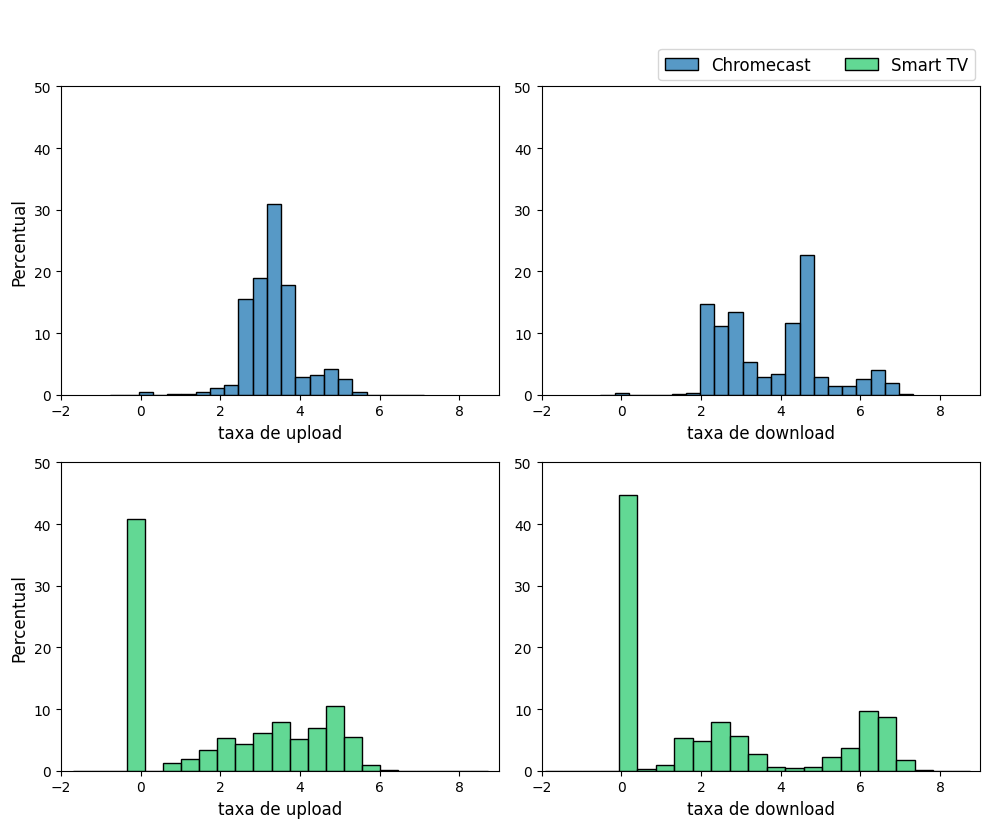

In [39]:
label_fontsize = 12
stat = "percent"
ylabel = "Percentual"

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

sns.histplot(data = df_chromecast,
             x = "log_taxa_upload",
             bins = chromecast_sturge_nbins,
             stat = stat,
             ax=axes[0, 0],
             label = "Chromecast")
axes[0, 0].set_ylabel(ylabel, fontsize = label_fontsize)
axes[0, 0].set_xlabel("taxa de upload", fontsize = label_fontsize)
axes[0, 0].set_ylim(0, 50)
axes[0, 0].set_xlim(-2, 9)

sns.histplot(data = df_chromecast,
             x = "log_taxa_download",
             bins = chromecast_sturge_nbins,
             stat = stat,
             ax=axes[0, 1])
axes[0, 1].set_ylabel("")
axes[0, 1].set_xlabel("taxa de download", fontsize = label_fontsize)
axes[0, 1].set_ylim(0, 50)
axes[0, 1].set_xlim(-2, 9)

sns.histplot(data = df_smart,
             x = "log_taxa_upload",
             bins = smart_sturge_nbins,
             stat = stat,
             ax=axes[1, 0],
             color = "#2ecc71",
             label = "Smart TV")
axes[1, 0].set_ylabel(ylabel, fontsize = label_fontsize)
axes[1, 0].set_xlabel("taxa de upload", fontsize = label_fontsize)
axes[1, 0].set_ylim(0, 50)
axes[1, 0].set_xlim(-2, 9)

sns.histplot(data = df_smart,
             x = "log_taxa_download",
             bins = smart_sturge_nbins,
             stat = stat,
             ax=axes[1, 1],
             color = "#2ecc71")
axes[1, 1].set_ylabel("")
axes[1, 1].set_xlabel("taxa de download", fontsize = label_fontsize)
axes[1, 1].set_ylim(0, 50)
axes[1, 1].set_xlim(-2, 9)

fig.suptitle(" ", y = 1.03)
# fig.suptitle("Histogramas das taxas de upload e download para cada dispositivo (log)", y = 1.03)

fig.legend(loc='upper right', bbox_to_anchor=(0.98, 0.98), ncol=2, borderaxespad=0., fontsize='12')
plt.tight_layout()

plt.savefig("./est_gerais_histograma.png", dpi = 300)
plt.show()

### Função distribuição empírica

In [40]:
# Calcular a função de distribuição empírica (ECDF)
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(data) + 1) / len(data)
    return x, y

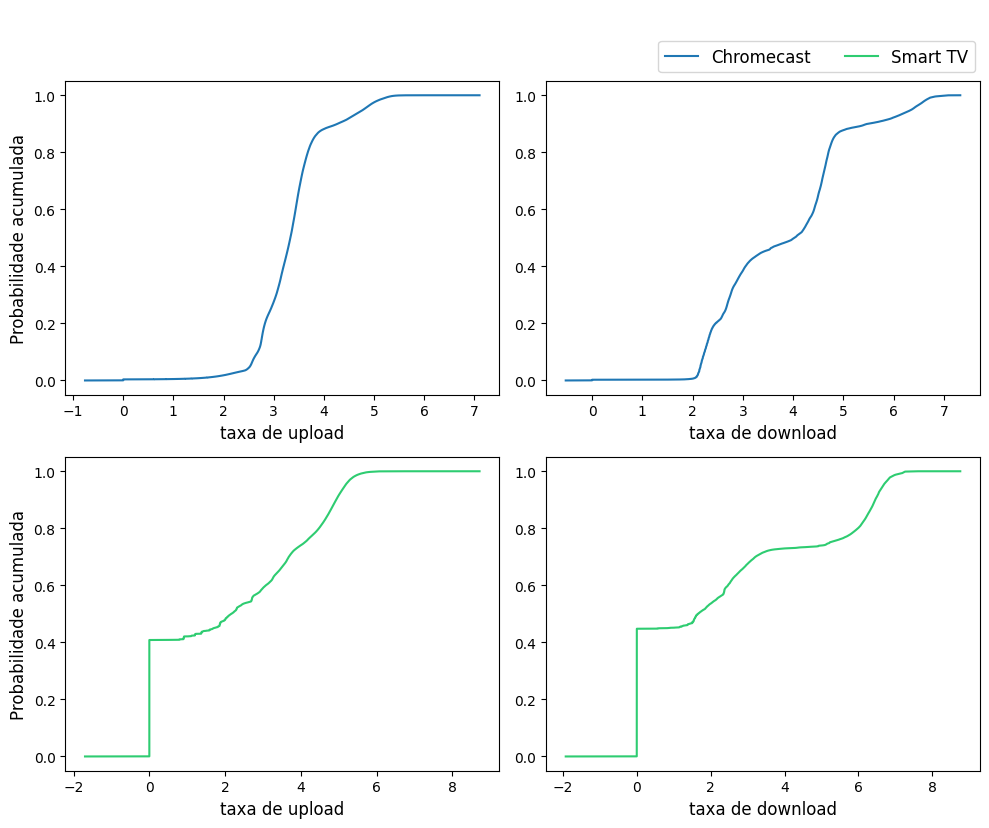

In [41]:
label_fontsize = 12
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

x, y = ecdf(df_chromecast['log_taxa_upload'])
axes[0, 0].plot(x,
                y,
                label = "Chromecast")
axes[0, 0].set_ylabel("Probabilidade acumulada", fontsize = label_fontsize)
axes[0, 0].set_xlabel("taxa de upload", fontsize = label_fontsize)

x, y = ecdf(df_chromecast['log_taxa_download'])
axes[0, 1].plot(x,
                y)
axes[0, 1].set_ylabel("")
axes[0, 1].set_xlabel("taxa de download", fontsize = label_fontsize)

x, y = ecdf(df_smart['log_taxa_upload'])
axes[1, 0].plot(x,
                y,
                label = "Smart TV",
                color = "#2ecc71")
axes[1, 0].set_ylabel("Probabilidade acumulada", fontsize = label_fontsize)
axes[1, 0].set_xlabel("taxa de upload", fontsize = label_fontsize)

x, y = ecdf(df_smart['log_taxa_download'])
axes[1, 1].plot(x,
                y,
                color = "#2ecc71")
axes[1, 1].set_ylabel("")
axes[1, 1].set_xlabel("taxa de download", fontsize = label_fontsize)

fig.suptitle(" ", y = 1.03)
# fig.suptitle("Função de distribuição empírica das taxas de upload e download para cada dispositivo", y = 1.03)

fig.legend(loc='upper right', bbox_to_anchor=(0.98, 0.99), ncol=2, borderaxespad=0., fontsize='12')
plt.tight_layout()

plt.savefig("./est_gerais_dist_empirica.png", dpi = 300)
plt.show()

### Box plot: **taxa de upload** e **taxa de download**

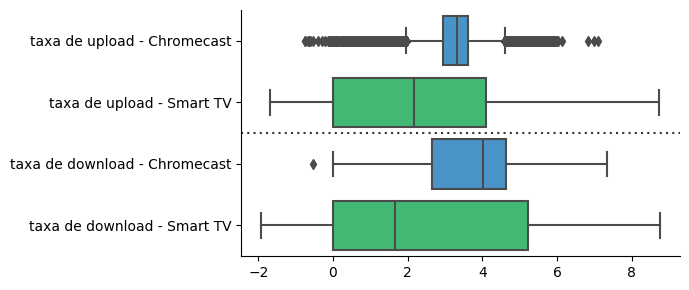

In [42]:
colunas = ["log_taxa_upload", "log_taxa_download"]

combined_dfs = pd.DataFrame({"taxa de upload - Chromecast"   : df_chromecast[colunas[0]],
                             "taxa de upload - Smart TV"      : df_smart[colunas[0]],
                             "taxa de download - Chromecast" : df_chromecast[colunas[1]],
                             "taxa de download - Smart TV"    : df_smart[colunas[1]]})

plt.figure(figsize = (7, 3))

cor_classe_chromecast = "#3498db"
cor_classe_smarttv = "#2ecc71"

cores = [cor_classe_chromecast, cor_classe_smarttv, cor_classe_chromecast, cor_classe_smarttv]
paleta = sns.color_palette(cores)

sns.boxplot(data = combined_dfs, palette = paleta, orient = "h")
plt.axhline(1.5, color=".2", dashes=(1, 2))
sns.despine()

plt.tight_layout()
plt.savefig("./est_gerais_boxplot.png", dpi = 300)
plt.show()

_________________________________

### Média, Variância e Desvio Padrão

In [43]:
colunas = ["log_taxa_upload", "log_taxa_download"]

**Chromecast**

In [44]:
chromecast_stats = pd.DataFrame({"Média"          : [round(df_chromecast[colunas[0]].mean(), 3), round(df_chromecast[colunas[1]].mean(), 3)],
                                 "Variância"      : [round(df_chromecast[colunas[0]].var(), 3), round(df_chromecast[colunas[1]].var(), 3)],
                                 "Desvio padrão"  : [round(df_chromecast[colunas[0]].std(), 3), round(df_chromecast[colunas[1]].std(), 3)]},
                                 index = ["taxa de upload", "taxa de download"])
chromecast_stats

,Média,Variância,Desvio padrão
taxa de upload,3.350,0.462,0.679
taxa de download,3.799,1.666,1.291


**Smart TV**

In [45]:
smart_stats = pd.DataFrame({"Média"          : [round(df_smart[colunas[0]].mean(), 3), round(df_smart[colunas[1]].mean(), 3)],
                            "Variância"      : [round(df_smart[colunas[0]].var(), 3), round(df_smart[colunas[1]].var(), 3)],
                            "Desvio padrão"  : [round(df_smart[colunas[0]].std(), 3), round(df_smart[colunas[1]].std(), 3)]},
                            index = ["taxa de upload", "taxa de download"])
smart_stats

,Média,Variância,Desvio padrão
taxa de upload,2.157,4.113,2.028
taxa de download,2.350,6.724,2.593


## Estatísticas por horário

**ATIVIDADES PRINCIPAIS**

O objetivo dessa análise é avaliar os dados considerando o horário em que foram gerados independente do dia. Você deve considerar os dados coletados em cada hora para cada tipo de dispositivo para obter as estatísticas descritas a seguir.

Para cada tipo de dispositivo, Smart-TV e Chromecast, calcular **taxa de upload** e **taxa de download**:

* Box Plot
* Média
* Variância
* Desvio Padrão

Com relação aos box plots, para poder compará-los:

* **Gerar 4 gráficos (cada um com 24 boxplots - um pra cada hora)**: taxa de upload (Smart-TV e Chromecast) e taxa de download (Smart-TV e Chromecast)

Com relação a média, variância e desvio padrão, para poder compará-los:

* **Gerar 4 gráficos**, representando no eixo X a hora e no eixo Y os valores das três estatísticas para cada taxa coletada, para cada tipo de dispositivo.

**Comente o que você observou a partir dos gráficos e sobre as diferenças e/ou similaridades entre os dois tipos de dispositivos.**

___________________

### Box plot: **taxa de upload** e **taxa de download**

**Chromecast**

In [46]:
df_chromecast["dt_hr"] = df_chromecast["hora"].apply(lambda x: x.split(":")[0])

In [47]:
def criar_boxplots_hora(dataframe: pd.DataFrame, x_column_name: str, y_column_name: str, color: str, title_core_name: str, device_name: str, show_title: bool = True, savefig: bool = True):
    plt.figure(figsize=(12, 4))
    sns.boxplot(x = x_column_name, y = y_column_name, data = dataframe, color = color)
    plt.xlabel("Hora do dia", fontsize = 12)
    taxa_name = title_core_name.split(' ')[-1]
    plt.ylabel(f"Taxa de {taxa_name}", fontsize = 12)
    if show_title:
        plt.title(f"Boxplots agrupados por hora do dia para a {title_core_name} (log)")

    plt.tight_layout()
    if savefig:
      filename = f"./est_horario_boxplot_taxa_{taxa_name}_{device_name}.png"
      plt.savefig(filename, dpi = 300)

    plt.show()

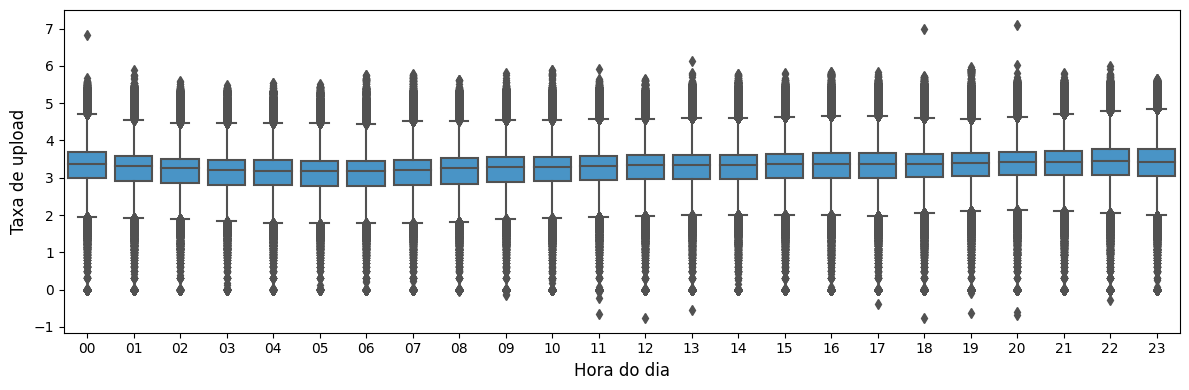

In [48]:
criar_boxplots_hora(dataframe = df_chromecast,
                    x_column_name = "dt_hr",
                    y_column_name = "log_taxa_upload",
                    color = "#3498db",
                    title_core_name = "taxa de upload",
                    device_name = "chromecast",
                    show_title = False)

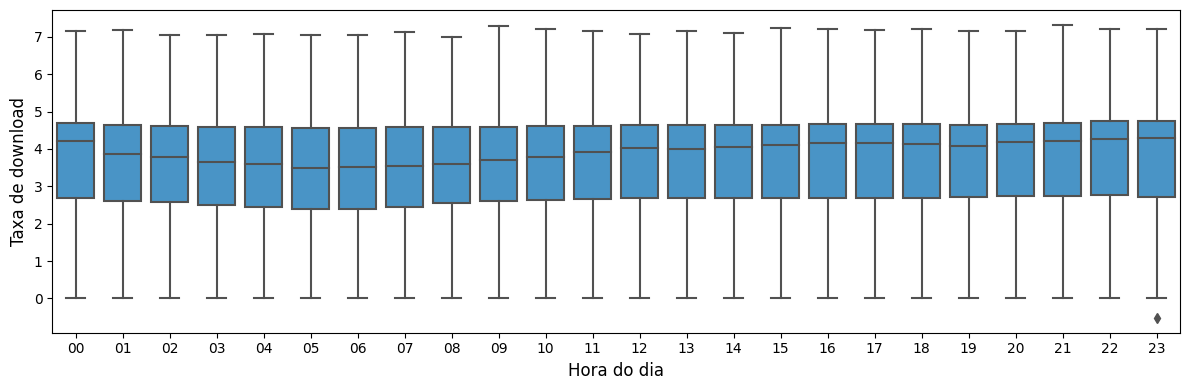

In [49]:
criar_boxplots_hora(dataframe = df_chromecast,
                    x_column_name = "dt_hr",
                    y_column_name = "log_taxa_download",
                    color = "#3498db",
                    title_core_name = "taxa de download",
                    device_name = "chromecast",
                    show_title = False)

**Smart TV**

In [50]:
df_smart["dt_hr"] = df_smart["hora"].apply(lambda x: x.split(":")[0])

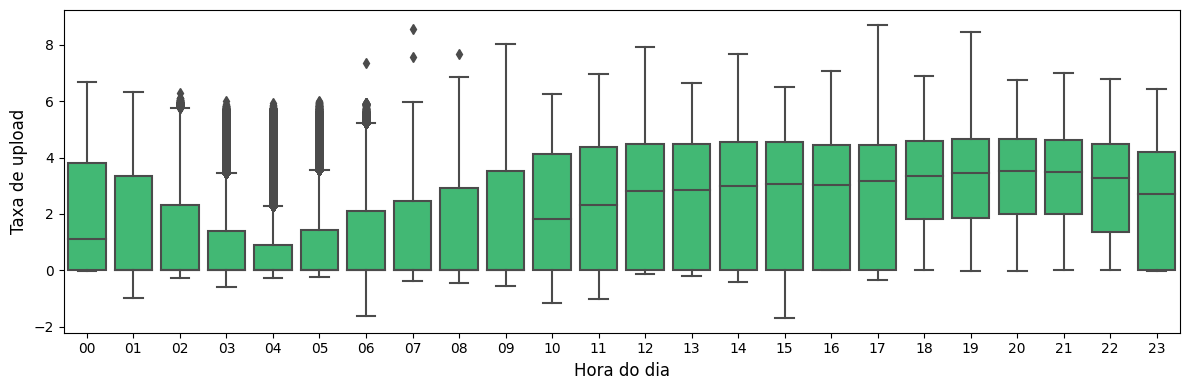

In [51]:
criar_boxplots_hora(dataframe = df_smart.sort_values(by = "dt_hr"),
                    x_column_name = "dt_hr",
                    y_column_name = "log_taxa_upload",
                    color = "#2ecc71",
                    title_core_name = "taxa de upload",
                    device_name = "smarttv",
                    show_title = False)

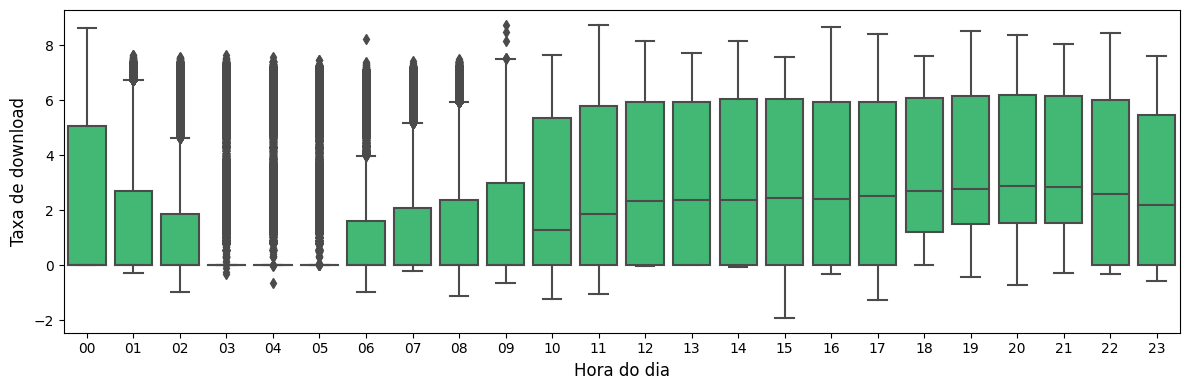

In [52]:
criar_boxplots_hora(dataframe = df_smart.sort_values(by = "dt_hr"),
                    x_column_name = "dt_hr",
                    y_column_name = "log_taxa_download",
                    color = "#2ecc71",
                    title_core_name = "taxa de download",
                    device_name = "smarttv",
                    show_title = False)

### Média, Variância e Desvio Padrão

In [53]:
def criar_barplots_hora(dataframe: pd.DataFrame, title_core_name: str, device_name: str, var_interesse: str = 'dt_hr', lowline: float = 0.5, upline: float = 3.0, savefig: bool = True):
    fig, ax = plt.subplots(figsize=(10, 3.5))

    barWidth = 0.25

    r1 = np.arange(len(dataframe[var_interesse]))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]

    ax.bar(r1, dataframe['mean'], color='#2a9d8f', width=barWidth, edgecolor='white', label='Média')
    ax.bar(r2, dataframe['var'], color='#e9c46a', width=barWidth, edgecolor='white', label='Variância')
    ax.bar(r3, dataframe['std'], color='#f4a261', width=barWidth, edgecolor='white', label='Desvio Padrão')

    ax.set_xlabel('Hora do dia', fontsize = 12)

    taxa_name = title_core_name.split(' ')[-1]
    ax.set_ylabel(f"Taxa de {taxa_name}", fontsize = 12)

    # ax.set_title(f' ', y = 1.15)
    # ax.set_title(f'Estatísticas por hora da {title_core_name}', y = 1.15)

    plt.xticks([r + barWidth for r in range(len(dataframe[var_interesse]))], dataframe[var_interesse])
    plt.axhline(lowline, color="#6c757d", dashes=(2, 2))
    plt.axhline(upline, color="#6c757d", dashes=(2, 2))

    plt.margins(x=0.01)
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1.12), ncol=3, borderaxespad=0., title_fontsize='12')

    plt.tight_layout()

    if savefig:
      filename = f"./est_horario_mvd_taxa_{taxa_name}_{device_name}.png"
      plt.savefig(filename, dpi = 300)

    plt.show()

**Chromecast - taxa de upload**

In [54]:
tx_up_chromecast_stats = df_chromecast.groupby("dt_hr")["log_taxa_upload"].agg(['mean', 'var', 'std']).reset_index()

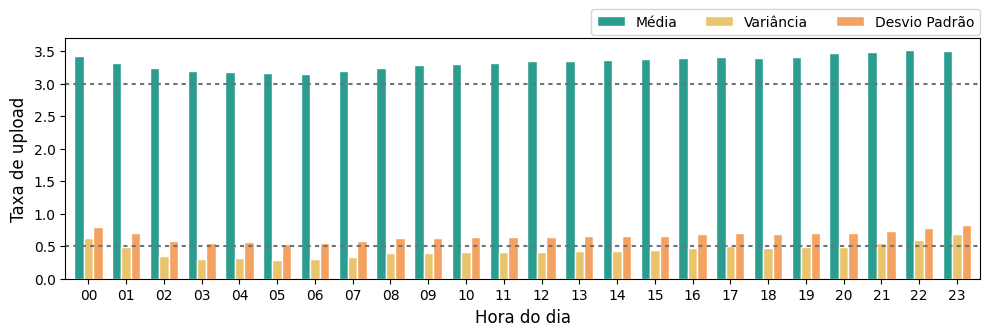

In [55]:
criar_barplots_hora(dataframe = tx_up_chromecast_stats,
                    title_core_name = "taxa de upload",
                    device_name = "chromecast")

**Chromecast - taxa de download**

In [56]:
tx_dw_chromecast_stats = df_chromecast.groupby("dt_hr")["log_taxa_download"].agg(['mean', 'var', 'std']).reset_index()

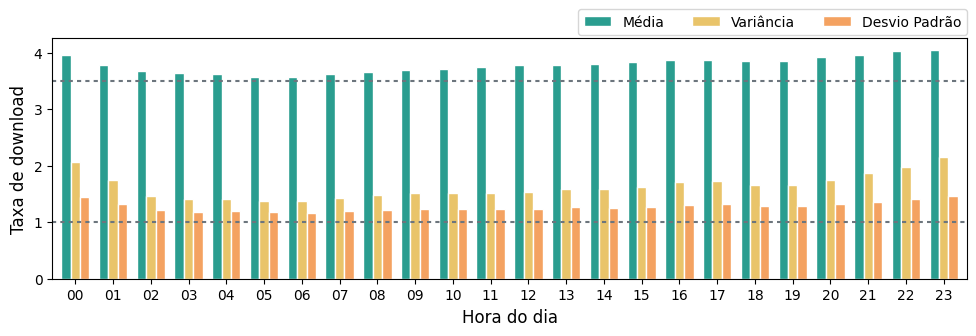

In [57]:
criar_barplots_hora(dataframe = tx_dw_chromecast_stats,
                    title_core_name = "taxa de download",
                    device_name = "chromecast",
                    lowline = 1.0,
                    upline = 3.5)

**Smart TV - taxa de upload**

In [58]:
tx_up_smart_stats = df_smart.groupby("dt_hr")["log_taxa_upload"].agg(['mean', 'var', 'std']).reset_index()

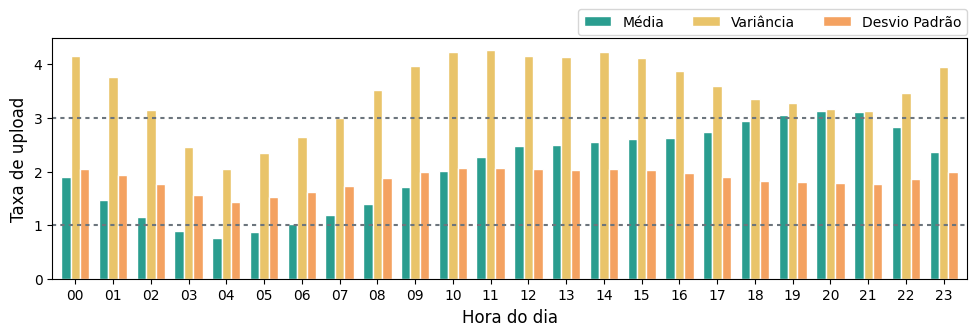

In [59]:
criar_barplots_hora(dataframe = tx_up_smart_stats,
                    title_core_name = "taxa de upload",
                    device_name = "smarttv",
                    lowline = 1.0)

**Smart TV - taxa de download**

In [60]:
tx_dw_smart_stats = df_smart.groupby("dt_hr")["log_taxa_download"].agg(['mean', 'var', 'std']).reset_index()

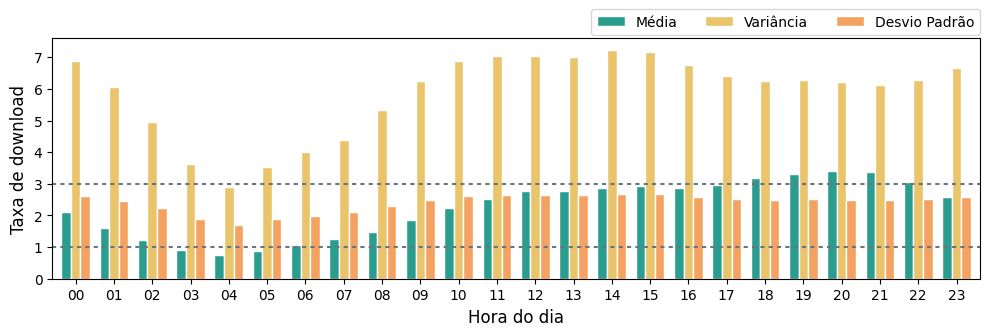

In [61]:
criar_barplots_hora(dataframe = tx_dw_smart_stats,
                    title_core_name = "taxa de download",
                    device_name = "smarttv",
                    lowline = 1.0)

______________________________

## Caracterizando os horários com maior valor de tráfego

**ATIVIDADES PRINCIPAIS**

Analisar os dois horários com maior valor da média de cada taxa coletada para cada tipo de dispositivo.

**Etapa 1**:

Escolher, a partir dos gráficos da seção anterior, o horário com maior valor de média, para a taxa de upload e taxa de download, para cada tipo de dispositivo: Smart-TV e Chromecast.

- Dataset 1: Horário com a maior média da taxa de upload em uma hora, Smart-TV
- Dataset 2: Horário com a maior média da taxa de download em uma hora, Smart-TV
- Dataset 3: Horário com a maior média da taxa de upload em uma hora, Chromecast
- Dataset 4: Horário com a maior média da taxa de download em uma hora, Chromecast

**Etapa 2**:

Faça um histograma para cada um dos 4 datasets.

*Lembre-se que você deve escolher o tamanho do bin usando o método de Sturges.*

**Etapa 3**:

Calcule, para cada um dos 4 datasets, o maximum likelihood estimator (MLE) para estimar os parâmetros das seguintes distribuições:

- Gaussiana
- Gamma

*Explique como foi calculado o MLE.*

**Etapa 4**:

Fazer um gráfico para cada um dos 4 datasets contendo 3 curvas:

- histograma
- função densidade Gaussiana com os parâmetros obtidos com o MLE
- função densidade Gamma com os parâmetros obtidos com o MLE.

**Observando os gráficos, comente se existe ou não uma variável aleatória da literatura que possivelmente
possa ser usada para representar os dados de cada um dos 4 datasets.**

**Etapa 5**:

Fazer o gráfico *Probability Plot* comparando os dados de cada dataset com as distribuições parametrizadas.

* No total são **8 gráficos, comparando os dados
reais dos 4 datasets** com cada uma das duas distribuições parametrizadas.

**Etapa 6**:

Fazer o gráfico QQ Plot comparando:

* Os dados do dataset 1 com aqueles do dataset 3
* Os dados do dataset 2 com aqueles do dataset 4

Obs.: **Serão dois gráficos, um para cada tipo de taxa**: download e upload.

**Etapa 7**:

Analisar as seguintes questões:

1. Quais foram os horários escolhidos para cada dataset?
2. O que você pode observar a partir dos histogramas dos datasets?
3. Comente sobre as diferenças e/ou similaridades entre os datasets 1, 2, 3 e 4.
4. E possível caracterizar os datasets acima por uma variável aleatória da literatura?
5. Se a resposta for não, qual o motivo?
6. O que você pôde observar a partir dos gráficos QQ Plot e Probability Plot?

______________________

### Etapa 1

**Obtendo horários com maior média de upload e download**

**Smart TV**

In [62]:
df_temp = tx_up_smart_stats[tx_up_smart_stats['mean'] == tx_up_smart_stats['mean'].max()]
tx_up_smart_hr = df_temp['dt_hr'].values[0]

print(f"Média do dataset 1 - maior taxa de upload: {df_temp['mean'].values[0]}")
print(f"Hora escolhida: {tx_up_smart_hr}")

Média do dataset 1 - maior taxa de upload: 3.1228041894721748
Hora escolhida: 20


In [63]:
df_temp = tx_dw_smart_stats[tx_dw_smart_stats['mean'] == tx_dw_smart_stats['mean'].max()]
tx_dw_smart_hr = df_temp['dt_hr'].values[0]

print(f"Média do dataset 2 - maior taxa de download: {df_temp['mean'].values[0]}")
print(f"Hora escolhida: {tx_dw_smart_hr}")

Média do dataset 2 - maior taxa de download: 3.394022293399694
Hora escolhida: 20


**Chromecast**

In [64]:
df_temp = tx_up_chromecast_stats[tx_up_chromecast_stats['mean'] == tx_up_chromecast_stats['mean'].max()]
tx_up_chromecast_hr = df_temp['dt_hr'].values[0]

print(f"Média do dataset 3 - maior taxa de upload: {df_temp['mean'].values[0]}")
print(f"Hora escolhida: {tx_up_chromecast_hr}")

Média do dataset 3 - maior taxa de upload: 3.521018359629227
Hora escolhida: 22


In [65]:
df_temp = tx_dw_chromecast_stats[tx_dw_chromecast_stats['mean'] == tx_dw_chromecast_stats['mean'].max()]
tx_dw_chromecast_hr = df_temp['dt_hr'].values[0]

print(f"Média do dataset 4 - maior taxa de download: {df_temp['mean'].values[0]}")
print(f"Hora escolhida: {tx_dw_chromecast_hr}")

Média do dataset 4 - maior taxa de download: 4.05206534060822
Hora escolhida: 23


**Adequação ao objetivo da análise**

*Se o horário com a maior taxa média de download for diferente do horário com a maior taxa média de upload*, **use os dados de upload do horário com a maior taxa média de download.** O objetivo é comparar dados de download e upload de um mesmo horário.

In [66]:
tx_up_chromecast_hr = tx_dw_chromecast_hr
print(f"Hora adequada: {tx_up_chromecast_hr}")

Hora adequada: 23


**Organizando cada dataset para análise 1-4**

In [67]:
### DATASET 1 ###
df1 = df_smart[df_smart['dt_hr'] == tx_up_smart_hr][["log_taxa_upload"]]
df1.head(2)

,log_taxa_upload
268,4.566219
269,4.897413


In [68]:
### DATASET 2 ###
df2 = df_smart[df_smart['dt_hr'] == tx_dw_smart_hr][["log_taxa_download"]]
df2.head(2)

,log_taxa_download
268,5.915829
269,6.145693


In [69]:
### DATASET 3 ###
df3 = df_chromecast[df_chromecast['dt_hr'] == tx_up_chromecast_hr][["log_taxa_upload"]]
df3.head(2)

,log_taxa_upload
1312,2.973158
1313,3.335244


In [70]:
### DATASET 4 ###
df4 = df_chromecast[df_chromecast['dt_hr'] == tx_dw_chromecast_hr][["log_taxa_download"]]
df4.head(2)

,log_taxa_download
1312,2.537055
1313,4.576242


### Etapa 2

**Calculando número de bins por Sturges**

In [71]:
### DATASET 1 ###
df1_nbins = obter_nbins_sturge(df1.shape[0])
df1_nbins

19

In [72]:
### DATASET 2 ###
df2_nbins = obter_nbins_sturge(df2.shape[0])
df2_nbins

19

In [73]:
### DATASET 3 ###
df3_nbins = obter_nbins_sturge(df3.shape[0])
df3_nbins

17

In [74]:
### DATASET 4 ###
df4_nbins = obter_nbins_sturge(df4.shape[0])
df4_nbins

17

**Verificando eixos**

In [75]:
df1.min()[0]

-0.020555754855611983

In [76]:
print(f"DF1: Min> {df1.min()[0]} | Max> {df1.max()[0]}")
print(f"DF2: Min> {df2.min()[0]} | Max> {df2.max()[0]}")
print(f"DF3: Min> {df3.min()[0]} | Max> {df3.max()[0]}")
print(f"DF4: Min> {df4.min()[0]} | Max> {df4.max()[0]}")

DF1: Min> -0.020555754855611983 | Max> 6.75121423520556
DF2: Min> -0.7078392285523384 | Max> 8.375961325657538
DF3: Min> 0.0 | Max> 5.654991229841871
DF4: Min> -0.5247408566113486 | Max> 7.2091217195823525


**Visualização**

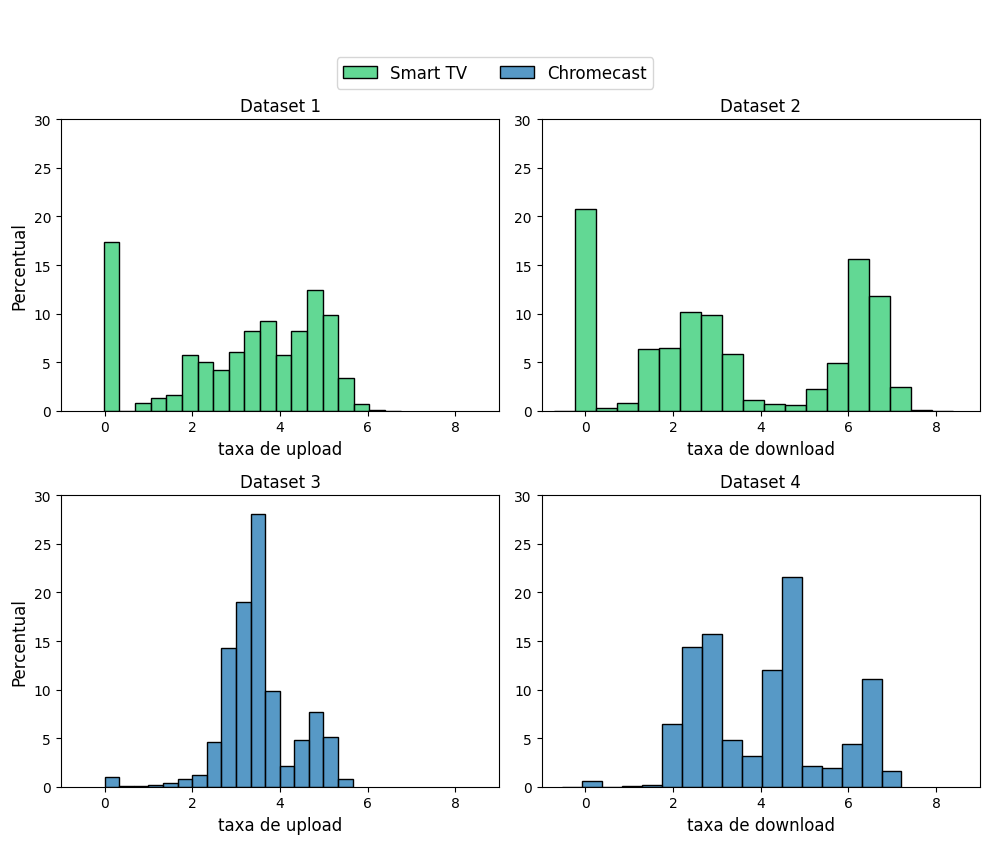

In [77]:
label_fontsize = 12
stat = "percent"
ylabel = "Percentual"

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

sns.histplot(data = df1,
             x = "log_taxa_upload",
             bins = df1_nbins,
             stat = stat,
             ax=axes[0, 0],
             color = "#2ecc71",
             label = "Smart TV")
axes[0, 0].set_title("Dataset 1")
axes[0, 0].set_ylabel(ylabel, fontsize = label_fontsize)
axes[0, 0].set_xlabel("taxa de upload", fontsize = label_fontsize)
axes[0, 0].set_ylim(0, 30)
axes[0, 0].set_xlim(-1, 9)

sns.histplot(data = df2,
             x = "log_taxa_download",
             bins = df2_nbins,
             stat = stat,
             ax=axes[0, 1],
             color = "#2ecc71")
axes[0, 1].set_title("Dataset 2")
axes[0, 1].set_ylabel("")
axes[0, 1].set_xlabel("taxa de download", fontsize = label_fontsize)
axes[0, 1].set_ylim(0, 30)
axes[0, 1].set_xlim(-1, 9)

sns.histplot(data = df3,
             x = "log_taxa_upload",
             bins = df3_nbins,
             stat = stat,
             ax=axes[1, 0],
             label = "Chromecast")
axes[1, 0].set_title("Dataset 3")
axes[1, 0].set_ylabel(ylabel, fontsize = label_fontsize)
axes[1, 0].set_xlabel("taxa de upload", fontsize = label_fontsize)
axes[1, 0].set_ylim(0, 30)
axes[1, 0].set_xlim(-1, 9)

sns.histplot(data = df4,
             x = "log_taxa_download",
             bins = df4_nbins,
             stat = stat,
             ax=axes[1, 1])
axes[1, 1].set_title("Dataset 4")
axes[1, 1].set_ylabel("")
axes[1, 1].set_xlabel("taxa de download", fontsize = label_fontsize)
axes[1, 1].set_ylim(0, 30)
axes[1, 1].set_xlim(-1, 9)

fig.suptitle(" ", y = 1.05)
# fig.suptitle("Histogramas das taxas de upload e download para cada dispositivo (log)", y = 1)

fig.legend(loc='center', bbox_to_anchor=(0.5, 0.97), ncol=2, borderaxespad=0., fontsize='12')
fig.subplots_adjust(hspace=0.2)
plt.tight_layout()

plt.savefig("./est_mtrafego_histograma.png", dpi = 300)
plt.show()

### Etapa 3

**Método manual**

In [78]:
def likelihood_gaussiana(params, data):
    mu, std = params
    n = len(data)
    log_likelihood = -0.5 * n * np.log(2 * np.pi) - 0.5 * n * np.log(std ** 2) - 0.5 / (std ** 2) * np.sum((data - mu)**2)
    return -log_likelihood

def likelihood_gamma(params, data):
    shape, loc, scale = params
    n = len(data)
    log_likelihood = n * shape * np.log(scale) - n * np.log(gamma(shape)) + (shape - 1) * np.sum(np.log(data)) - scale * np.sum(data)
    return -log_likelihood

In [79]:
def calc_mle(dados, tipo_distr: str):
    if tipo_distr == "gauss":
        initial_params = [np.mean(dados), np.std(dados)]
        result = minimize(likelihood_gaussiana, initial_params, args=(dados,), method='L-BFGS-B')
        mu_mle, std_mle = result.x

        return mu_mle, std_mle

    if tipo_distr == "gamma":
        initial_params = [2, 0, np.mean(dados)]
        result = minimize(likelihood_gamma, initial_params, args=(dados,), method='L-BFGS-B')
        shape_mle, loc_mle, scale_mle = result.x

        return shape_mle, loc_mle, scale_mle

**Dataset 1**

In [80]:
### MLE - Gaussiana ###
df1_mu, df1_std = norm.fit(df1)

print(f'Média estimada: {df1_mu}')
print(f'Desvio padrão estimado: {df1_std}')

Média estimada: 3.122804189472175
Desvio padrão estimado: 1.7814307842228692


In [81]:
### MLE - Gamma ###
df1_shape, df1_loc, df1_scale = gamma.fit(df1)

print(f'Parâmetro de forma estimado: {df1_shape}')
print(f'Parâmetro de localização estimado: {df1_loc}')
print(f'Parâmetro de escala estimado: {df1_scale}')

Parâmetro de forma estimado: 209.5414387375581
Parâmetro de localização estimado: -23.34040210230087
Parâmetro de escala estimado: 0.12626185857832184


**Dataset 2**

In [82]:
### MLE - Gaussiana ###
df2_mu, df2_std = norm.fit(df2)

print(f'Média estimada: {df2_mu}')
print(f'Desvio padrão estimado: {df2_std}')

Média estimada: 3.394022293399694
Desvio padrão estimado: 2.491848561239433


In [83]:
### MLE - Gamma ###
df2_shape, df2_loc, df2_scale = gamma.fit(df2)

print(f'Parâmetro de forma estimado: {df2_shape}')
print(f'Parâmetro de localização estimado: {df2_loc}')
print(f'Parâmetro de escala estimado: {df2_scale}')

Parâmetro de forma estimado: 893.3317361585573
Parâmetro de localização estimado: -71.07563105104046
Parâmetro de escala estimado: 0.08336184655720486


**Dataset 3**

In [84]:
### MLE - Gaussiana ###
df3_mu, df3_std = norm.fit(df3)

print(f'Média estimada: {df3_mu}')
print(f'Desvio padrão estimado: {df3_std}')

Média estimada: 3.5071319184961887
Desvio padrão estimado: 0.8336106959712973


In [85]:
### MLE - Gamma ###
df3_shape, df3_loc, df3_scale = gamma.fit(df3)

print(f'Parâmetro de forma estimado: {df3_shape}')
print(f'Parâmetro de localização estimado: {df3_loc}')
print(f'Parâmetro de escala estimado: {df3_scale}')

Parâmetro de forma estimado: 504.9371237937329
Parâmetro de localização estimado: -15.451444358039122
Parâmetro de escala estimado: 0.03753945661760451


**Dataset 4**

In [86]:
### MLE - Gaussiana ###
df4_mu, df4_std = norm.fit(df4)

print(f'Média estimada: {df4_mu}')
print(f'Desvio padrão estimado: {df4_std}')

Média estimada: 4.05206534060822
Desvio padrão estimado: 1.4702340158247664


In [87]:
### MLE - Gamma ###
df4_shape, df4_loc, df4_scale = gamma.fit(df4)

print(f'Parâmetro de forma estimado: {df4_shape}')
print(f'Parâmetro de localização estimado: {df4_loc}')
print(f'Parâmetro de escala estimado: {df4_scale}')

Parâmetro de forma estimado: 27.264762975234554
Parâmetro de localização estimado: -3.6550707752725704
Parâmetro de escala estimado: 0.2826775424906913


### Etapa 4

**Gráfico com subplots**

In [88]:
def obter_pdfs(dados, gauss_params, gamma_params):
    xmin, xmax = min(dados), max(dados)
    x = np.linspace(xmin, xmax, 100)

    ## gaussiana ##
    pdf_gaussiana = norm.pdf(x = x, loc = gauss_params.get("mu"), scale = gauss_params.get("std"))
    ## gamma ##
    pdf_gamma = gamma.pdf(x = x, a = gamma_params.get("shape"), loc = gamma_params.get("loc"), scale = gamma_params.get("scale"))

    return x, pdf_gaussiana, pdf_gamma

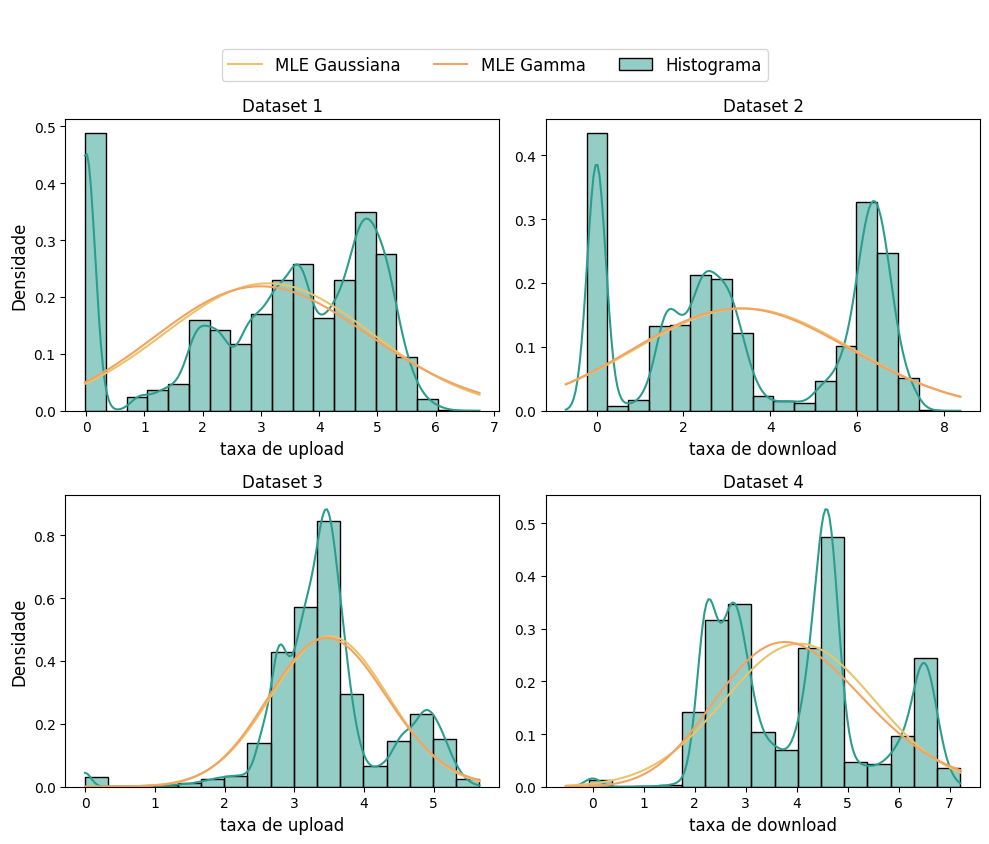

In [89]:
label_fontsize = 12
stat = "density"
ylabel = "Densidade"
cores = ["#2a9d8f", "#e9c46a", "#f4a261"]
colunas = ["log_taxa_upload", "log_taxa_download"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

### Dataset 1 ###
x, pdf_gaussiana, pdf_gamma = obter_pdfs(df1[colunas[0]], gauss_params = {"mu": df1_mu, "std": df1_std}, gamma_params = {"shape": df1_shape, "loc": df1_loc, "scale": df1_scale})

sns.histplot(data = df1[colunas[0]], bins = df1_nbins, stat = stat, kde = True, color = cores[0], ax=axes[0, 0], label = "Histograma")
sns.lineplot(x = x, y = pdf_gaussiana, color = cores[1], ax=axes[0, 0], label = "MLE Gaussiana")
sns.lineplot(x = x, y = pdf_gamma, color = cores[2], ax=axes[0, 0], label = "MLE Gamma")
axes[0, 0].legend_.remove()
axes[0, 0].set_title("Dataset 1")
axes[0, 0].set_ylabel(ylabel, fontsize = label_fontsize)
axes[0, 0].set_xlabel("taxa de upload", fontsize = label_fontsize)
# axes[0, 0].set_ylim(0, 30)
# axes[0, 0].set_xlim(-1, 9)

### Dataset 2 ###
x, pdf_gaussiana, pdf_gamma = obter_pdfs(df2[colunas[1]], gauss_params = {"mu": df2_mu, "std": df2_std}, gamma_params = {"shape": df2_shape, "loc": df2_loc, "scale": df2_scale})

sns.histplot(data = df2[colunas[1]], bins = df2_nbins, stat = stat, kde = True, color = cores[0], ax=axes[0, 1])
sns.lineplot(x = x, y = pdf_gaussiana, color = cores[1], ax=axes[0, 1])
sns.lineplot(x = x, y = pdf_gamma, color = cores[2], ax=axes[0, 1])
axes[0, 1].set_title("Dataset 2")
axes[0, 1].set_ylabel("")
axes[0, 1].set_xlabel("taxa de download", fontsize = label_fontsize)
# axes[0, 1].set_ylim(0, 30)
# axes[0, 1].set_xlim(-1, 9)

### Dataset 3 ###
x, pdf_gaussiana, pdf_gamma = obter_pdfs(df3[colunas[0]], gauss_params = {"mu": df3_mu, "std": df3_std}, gamma_params = {"shape": df3_shape, "loc": df3_loc, "scale": df3_scale})

sns.histplot(data = df3[colunas[0]], bins = df3_nbins, stat = stat, kde = True, color = cores[0], ax=axes[1, 0])
sns.lineplot(x = x, y = pdf_gaussiana, color = cores[1], ax=axes[1, 0])
sns.lineplot(x = x, y = pdf_gamma, color = cores[2], ax=axes[1, 0])
axes[1, 0].set_title("Dataset 3")
axes[1, 0].set_ylabel(ylabel, fontsize = label_fontsize)
axes[1, 0].set_xlabel("taxa de upload", fontsize = label_fontsize)
# axes[1, 0].set_ylim(0, 30)
# axes[1, 0].set_xlim(-1, 9)

### Dataset 4 ###
x, pdf_gaussiana, pdf_gamma = obter_pdfs(df4[colunas[1]], gauss_params = {"mu": df4_mu, "std": df4_std}, gamma_params = {"shape": df4_shape, "loc": df4_loc, "scale": df4_scale})

sns.histplot(data = df4[colunas[1]], bins = df4_nbins, stat = stat, kde = True, color = cores[0], ax=axes[1, 1])
sns.lineplot(x = x, y = pdf_gaussiana, color = cores[1], ax=axes[1, 1])
sns.lineplot(x = x, y = pdf_gamma, color = cores[2], ax=axes[1, 1])
axes[1, 1].set_title("Dataset 4")
axes[1, 1].set_ylabel("")
axes[1, 1].set_xlabel("taxa de download", fontsize = label_fontsize)
# axes[1, 1].set_ylim(0, 30)
# axes[1, 1].set_xlim(-1, 9)

fig.suptitle(" ", y = 1.05)
# fig.suptitle("Histogramas das taxas de upload e download para cada dispositivo (log)", y = 1)

fig.legend(loc='center', bbox_to_anchor=(0.5, 0.98), ncol=3, borderaxespad=0., fontsize='12')
fig.subplots_adjust(hspace=0.2)
plt.tight_layout()

plt.savefig("./est_mtrafego_mle.png", dpi = 300)
plt.show()

**Gráficos individuais** - 2ª alternativa

In [90]:
def criar_lineplot(dataframe: pd.DataFrame, nome_coluna: str, nbins: int, gauss_params: dict, gamma_params: dict):
    dados = dataframe[nome_coluna]

    xmin, xmax = min(dados), max(dados)
    x = np.linspace(xmin, xmax, 100)

    ## gaussiana ##
    pdf_gaussiana = norm.pdf(x, gauss_params.get("mu"), gauss_params.get("std"))
    ## gamma ##
    pdf_gamma = gamma.pdf(x, gamma_params.get("shape"), gamma_params.get("loc"), gamma_params.get("scale"))

    plt.figure(figsize=(8, 6))
    sns.set_style("white")

    sns.histplot(data = dados, bins = nbins, stat = 'density', kde = True, color = "#2a9d8f", label = "Histograma")
    sns.lineplot(x = x, y = pdf_gaussiana, color='#e9c46a', label='MLE Gaussiana')
    sns.lineplot(x = x, y = pdf_gamma, color='#f4a261', label='MLE Gamma')

    plt.title('Ajuste de Distribuições Gaussianas e Gamma')
    plt.xlabel('Valores')
    plt.ylabel('Densidade')
    plt.legend()
    plt.show()

**Dataset 1**

In [91]:
# criar_lineplot(dataframe = df1,
#                nome_coluna = "log_taxa_upload",
#                nbins = df1_nbins,
#                gauss_params = {"mu": df1_mu,
#                                "std": df1_std},
#                gamma_params = {"shape": df1_shape,
#                                "loc": df1_loc,
#                                "scale": df1_scale})

**Dataset 2**

In [92]:
# criar_lineplot(dataframe = df2,
#                nome_coluna = "log_taxa_download",
#                nbins = df2_nbins,
#                gauss_params = {"mu": df2_mu,
#                                "std": df2_std},
#                gamma_params = {"shape": df2_shape,
#                                "loc": df2_loc,
#                                "scale": df2_scale})

**Dataset 3**

In [93]:
# criar_lineplot(dataframe = df3,
#                nome_coluna = "log_taxa_upload",
#                nbins = df3_nbins,
#                gauss_params = {"mu": df3_mu,
#                                "std": df3_std},
#                gamma_params = {"shape": df3_shape,
#                                "loc": df3_loc,
#                                "scale": df3_scale})

**Dataset 4**

In [94]:
# criar_lineplot(dataframe = df4,
#                nome_coluna = "log_taxa_download",
#                nbins = df4_nbins,
#                gauss_params = {"mu": df4_mu,
#                                "std": df4_std},
#                gamma_params = {"shape": df4_shape,
#                                "loc": df4_loc,
#                                "scale": df4_scale})

### Etapa 5

In [95]:
def criar_prob_plot(dados: pd.Series, gauss_params: dict, gamma_params: dict, cor: str = "#3498db", filename: str = ""):
    label_fontsize = 12
    ylabel = "Dados"
    xlabel = "Quantis teóricos"

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    dados_ordenados = np.sort(dados)

    sp.stats.probplot(dados_ordenados, dist = norm, sparams = (gauss_params.get("mu"), gauss_params.get("std")), plot = axes[0])
    axes[0].set_title("Comparação com Gaussiana")
    axes[0].set_ylabel(ylabel, fontsize = label_fontsize)
    axes[0].set_xlabel(xlabel, fontsize = label_fontsize)
    axes[0].set_ylim(-1, 9)
    axes[0].get_lines()[0].set_markersize(3)
    axes[0].get_lines()[0].set_markerfacecolor("white")
    axes[0].get_lines()[0].set_markeredgecolor(cor)
    axes[0].get_lines()[1].set_color("black")
    axes[0].grid(True, alpha = 0.3)

    sp.stats.probplot(dados_ordenados, dist = gamma, sparams = (gamma_params.get("shape"), gamma_params.get("loc"), gamma_params.get("scale")), plot = axes[1])
    axes[1].set_title("Comparação com Gamma")
    axes[1].set_ylabel("")
    axes[1].set_xlabel(xlabel, fontsize = label_fontsize)
    axes[1].set_ylim(-1, 9)
    axes[1].get_lines()[0].set_markersize(3)
    axes[1].get_lines()[0].set_markerfacecolor("white")
    axes[1].get_lines()[0].set_markeredgecolor(cor)
    axes[1].get_lines()[1].set_color("black")
    axes[1].grid(True, alpha = 0.3)

    plt.tight_layout()

    plt.savefig(f"./est_mtrafego_probplot_{filename}.png", dpi = 300)
    plt.show()

**Dataset 1**

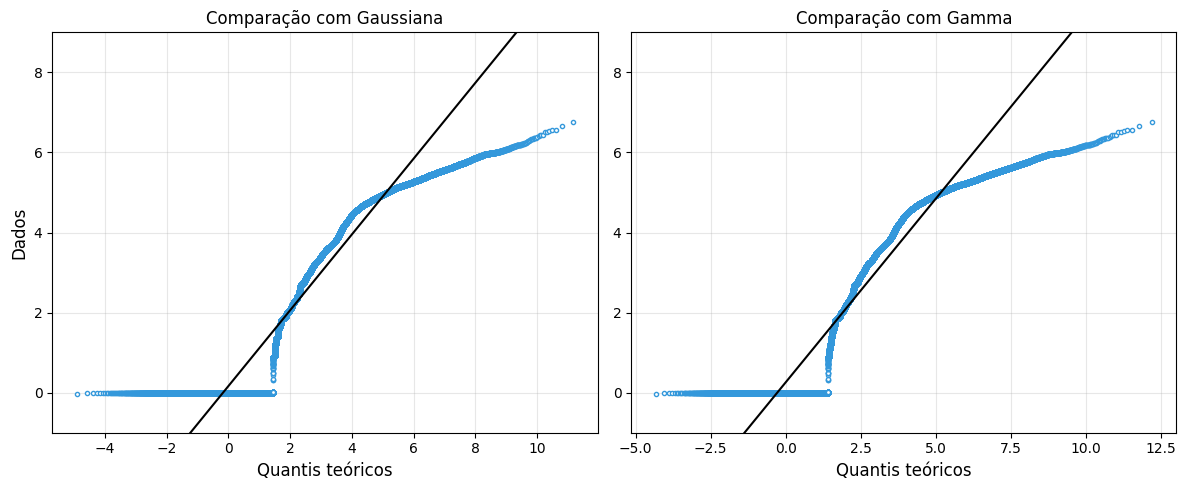

In [96]:
criar_prob_plot(dados = df1["log_taxa_upload"],
                gauss_params = {"mu": df1_mu, "std": df1_std},
                gamma_params = {"shape": df1_shape, "loc": df1_loc, "scale": df1_scale},
                filename = "dataset1")

**Dataset 2**

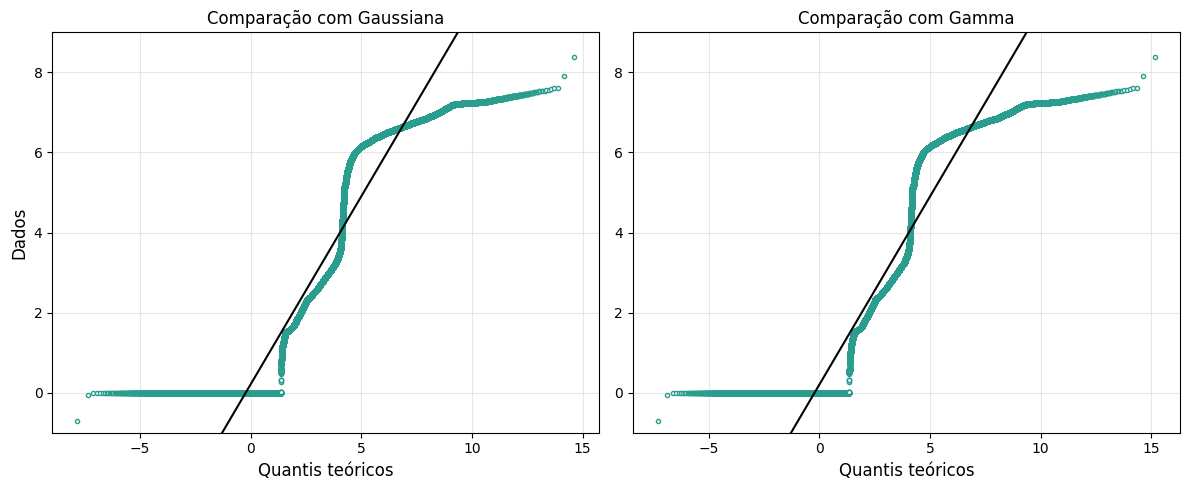

In [97]:
criar_prob_plot(dados = df2["log_taxa_download"],
                gauss_params = {"mu": df2_mu, "std": df2_std},
                gamma_params = {"shape": df2_shape, "loc": df2_loc, "scale": df2_scale},
                cor = "#2a9d8f",
                filename = "dataset2")

**Dataset 3**

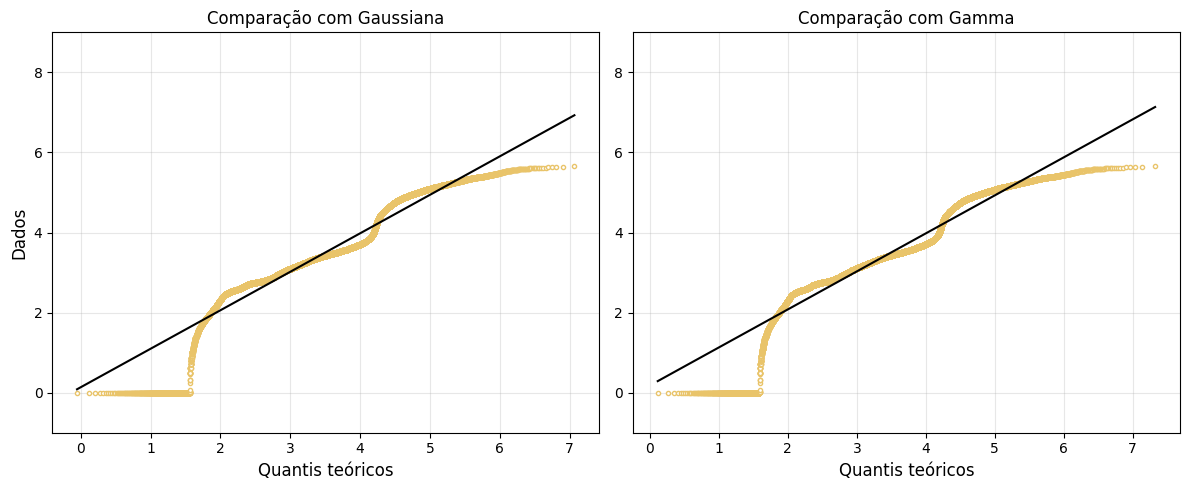

In [98]:
criar_prob_plot(dados = df3["log_taxa_upload"],
                gauss_params = {"mu": df3_mu, "std": df3_std},
                gamma_params = {"shape": df3_shape, "loc": df3_loc, "scale": df3_scale},
                cor = "#e9c46a",
                filename = "dataset3")

**Dataset 4**

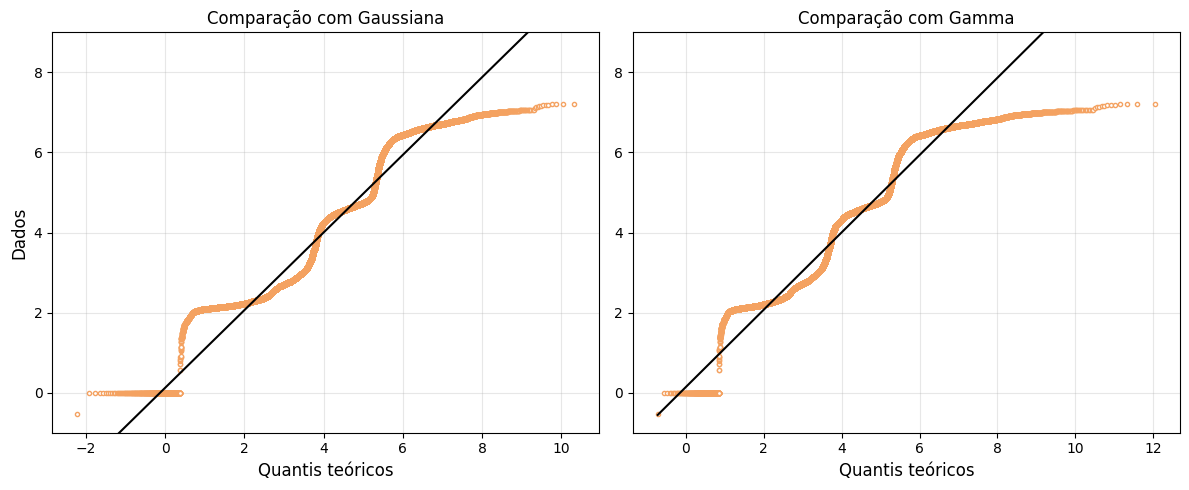

In [99]:
criar_prob_plot(dados = df4["log_taxa_download"],
                gauss_params = {"mu": df4_mu, "std": df4_std},
                gamma_params = {"shape": df4_shape, "loc": df4_loc, "scale": df4_scale},
                cor = "#f4a261",
                filename = "dataset4")

### Etapa 6

**Verificando tamanho dos datasets**

In [100]:
print(f"Tamanho do dataset 1: {len(df1)}")
print(f"Tamanho do dataset 3: {len(df3)}")

print("=================================")
print(f"Tamanho do dataset 2: {len(df2)}")
print(f"Tamanho do dataset 4: {len(df4)}")

Tamanho do dataset 1: 212608
Tamanho do dataset 3: 71848
Tamanho do dataset 2: 212608
Tamanho do dataset 4: 71848


**QQPLOT**

In [101]:
colunas = ["log_taxa_upload", "log_taxa_download"]

In [102]:
def criar_qqplot_2_amostras(amostra1: pd.Series,
                            amostra2: pd.Series,
                            label_1: str,
                            label_2: str,
                            label_fontsize: int = 12,
                            show_title: bool = False,
                            filename: str = ""):
    amostra1 = np.sort(amostra1)
    amostra2 = np.sort(amostra2)

    len_amostra1 = len(amostra1)
    len_amostra2 = len(amostra2)

    if len_amostra1 != len_amostra2:
        amostra_menor, lb_menor = (amostra1, label_1) if len_amostra1 < len_amostra2 else (amostra2, label_2)
        amostra_maior, lb_maior = (amostra1, label_1) if len_amostra1 > len_amostra2 else (amostra2, label_2)

        amostra_maior_interpolada = np.interp(np.linspace(0, 1, len(amostra_menor)), np.linspace(0, 1, len(amostra_maior)), amostra_maior)

        plt.scatter(amostra_maior_interpolada, amostra_menor, edgecolors='k', s = 25, facecolors='none', label='QQ Plot')
        plt.plot(amostra_maior_interpolada, amostra_maior_interpolada, color='red', linestyle='--', label='Linha de 45 graus')
        plt.xlabel(lb_menor, fontsize = label_fontsize)
        plt.ylabel(lb_maior, fontsize = label_fontsize)

    else:
        plt.scatter(amostra1, amostra2, edgecolors='k', s = 25, facecolors='none', label='QQ Plot')
        plt.plot(amostra1, amostra1, color='red', linestyle='--', label='Linha de 45 graus')

        plt.xlabel(label_1, fontsize = label_fontsize)
        plt.ylabel(label_2, fontsize = label_fontsize)

    if show_title:
        plt.title(f'QQ Plot entre {label_1} e {label_2}')

    plt.grid(True, alpha = 0.3)
    plt.tight_layout()

    plt.savefig(f"./est_mtrafego_qqplot_{filename}.png", dpi = 300)
    plt.show()


**Dataset 1 x Dataset 3**

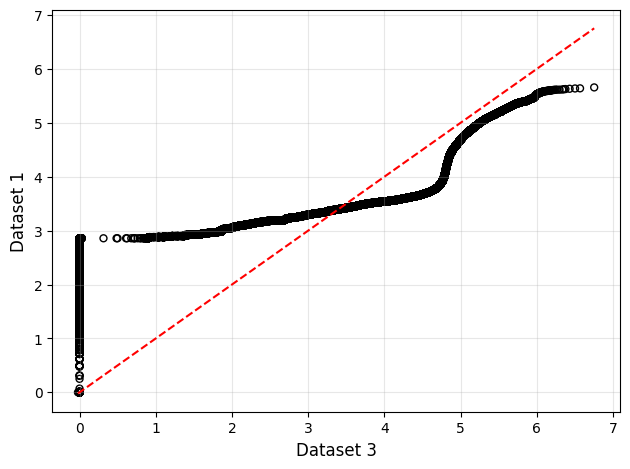

In [103]:
criar_qqplot_2_amostras(amostra1 = df1[colunas[0]],
                        amostra2 = df3[colunas[0]],
                        label_1 = "Dataset 1",
                        label_2 = "Dataset 3",
                        filename = "data1_data3")

**Dataset 2 x Dataset 4**

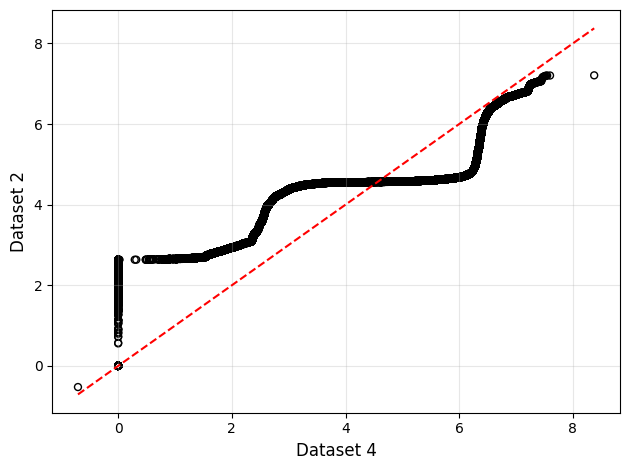

In [104]:
criar_qqplot_2_amostras(amostra1 = df2[colunas[1]],
                        amostra2 = df4[colunas[1]],
                        label_1 = "Dataset 2",
                        label_2 = "Dataset 4",
                        filename = "data2_data4")

_____________________

## Análise da correlação

**ATIVIDADES PRINCIPAIS**

Analisar se existe alguma correlação entre a taxa de upload e a
taxa de download de um mesmo dispositivo.

Calcular:

* Coeficiente de correlação amostral
* Fazer o gráfico scatter plot comparando as taxas dos seguintes datasets:  

  * Dataset 1 e Dataset 2
  * Dataset 3 e Dataset 4
  
**Gerar dois gráficos scatter plot, um para cada dispositivo, comparando as suas taxas.**

**Analisar os resultados e indicar se existe alguma correlação entre as taxas de download e upload dos dispositivos.**

_______________________

In [105]:
def criar_scatterplot(amostra1: pd.Series,
                      amostra2: pd.Series,
                      label_1: str,
                      label_2: str,
                      cor: str = "#3498db",
                      filename: str = ""):
    sns.scatterplot(x = amostra1, y = amostra2, color = cor)

    plt.xlabel(label_1, fontsize = 12)
    plt.ylabel(label_2, fontsize = 12)

    plt.tight_layout()

    plt.savefig(f"./est_corr_scatter_{filename}.png", dpi = 300)
    plt.show()

### Smart TV

**Correlação de Pearson**

In [106]:
coef_corr = df1['log_taxa_upload'].corr(df2['log_taxa_download'])
print(f"O coeficiente de correlação entre as taxas: {coef_corr}")

O coeficiente de correlação entre as taxas: 0.9154767447398775


**Scatter plot**

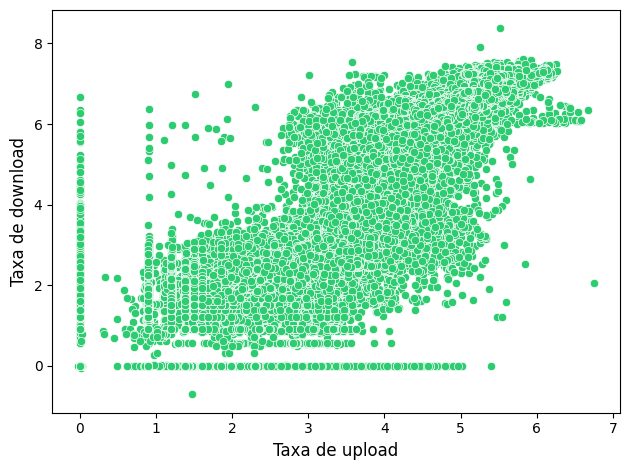

In [107]:
criar_scatterplot(amostra1 = df1['log_taxa_upload'],
                  amostra2 = df2['log_taxa_download'],
                  label_1 = "Taxa de upload",
                  label_2 = "Taxa de download",
                  cor = "#2ecc71",
                  filename = "smarttv")

### Chromecast

**Correlação de Pearson**

In [108]:
coef_corr = df3['log_taxa_upload'].corr(df4['log_taxa_download'])
print(f"O coeficiente de correlação entre as taxas: {coef_corr}")

O coeficiente de correlação entre as taxas: 0.7919586388345028


**Scatter plot**

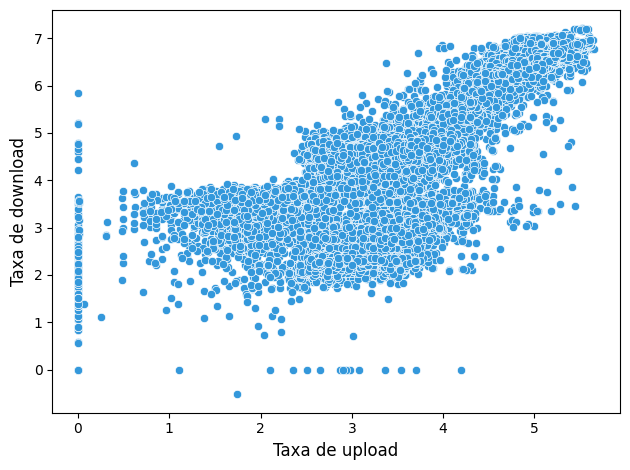

In [109]:
criar_scatterplot(amostra1 = df3['log_taxa_upload'],
                  amostra2 = df4['log_taxa_download'],
                  label_1 = "Taxa de upload",
                  label_2 = "Taxa de download",
                  filename = "chromecast")

## Comparando dados com teste de hipóteses

**ATIVIDADES PRINCIPAIS**

Avaliar se os dois dispositivos que são usados prioritariamente
para assistir vídeo, possuem distribuição de probabilidade das taxas de upload e download semelhante nos horários de maior tráfego.

Usar a estatística G do teste Chi-Square
for goodness of fit (apresentado em classe) para fazer essa análise:

  * Dataset 1 e Dataset 3
  * Dataset 2 e Dataset 4
  
Obs.: Note que para realizar o G-test entre cada par de datasets, o **número de bins e os valores dos bins dos histogramas dos datasets a serem comparados devem ser os mesmos**. Portanto, se os bins dos histogramas que você obteve na seção (Maior Tráfego) para um determinado par de datasets for diferente, **escolha o número de bins e os valores dos bins de um deles e use como referência
para aquele par de datasets**.

In [110]:
def obter_valores_observados_esperados(amostra1: pd.Series, amostra2: pd.Series, nbins: int, use_perc: bool = True):
    valor_observado, bins = np.histogram(amostra1, bins = nbins, density = False)
    valor_esperado, _ = np.histogram(amostra2, bins = bins, density = False)

    if use_perc:
        valor_observado_perc = np.array([v / sum(valor_observado) * 100 for v in valor_observado])
        valor_esperado_perc = np.array([v / sum(valor_esperado) * 100 for v in valor_esperado])

        return valor_observado_perc, valor_esperado_perc, bins
    return valor_observado, valor_esperado, bins

def criar_histogramas_ajustados(valor_observado: np.array, valor_esperado: np.array, bins: np.array, use_perc: bool = True, filename: str = ""):
    plt.bar(bins[:-1], valor_observado, width = np.diff(bins), color = "#05668d", alpha = 0.75, label = "Observado")
    plt.bar(bins[:-1], valor_esperado, width = np.diff(bins), color = "#02c39a", alpha = 0.5, label = "Esperado")

    ticks = np.arange(1, len(bins))
    plt.xticks(bins[:-1], ticks)
    plt.xlabel("Bins", fontsize = 12)
    plt.ylabel("Percentual" if use_perc else "Frequência", fontsize = 12)
    plt.legend(fontsize = 12)
    plt.tight_layout()

    plt.savefig(f"./est_gtest_{filename}.png", dpi = 300)
    plt.show()

def g_test(valor_observado: np.array, valor_esperado: np.array, significancia: float = 0.05):
    tabela_contingencia = np.array([valor_observado, valor_esperado])

    stat, p, _, _ = chi2_contingency(tabela_contingencia, lambda_="log-likelihood")

    print(f"Estatística G: {stat}")
    print(f"Valor p: {p:.4E}")

    alpha = significancia
    if p < alpha:
        print("Rejeitamos a hipótese nula, há diferença significativa entre os histogramas.")
    else:
        print("Não há evidências suficientes para rejeitar a hipótese nula.")

### Dataset 1 x Dataset 3

In [111]:
valor_observado, valor_esperado, bins = obter_valores_observados_esperados(amostra1 = df1,
                                                                           amostra2 = df3,
                                                                           nbins = df1_nbins)

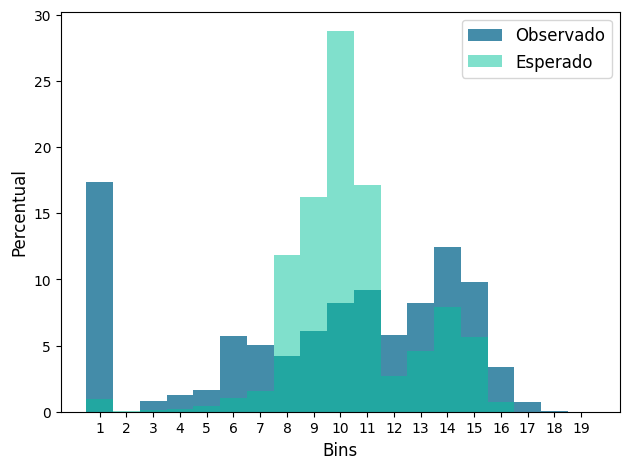

In [112]:
criar_histogramas_ajustados(valor_observado = valor_observado,
                            valor_esperado = valor_esperado,
                            bins = bins,
                            filename = "dataset1_3")

In [113]:
g_test(valor_observado = valor_observado,
       valor_esperado = valor_esperado)

Estatística G: 55.817897175313774
Valor p: 9.5219E-06
Rejeitamos a hipótese nula, há diferença significativa entre os histogramas.


### Dataset 2 x Dataset 4

In [114]:
valor_observado, valor_esperado, bins = obter_valores_observados_esperados(amostra1 = df2,
                                                                           amostra2 = df4,
                                                                           nbins = df2_nbins)

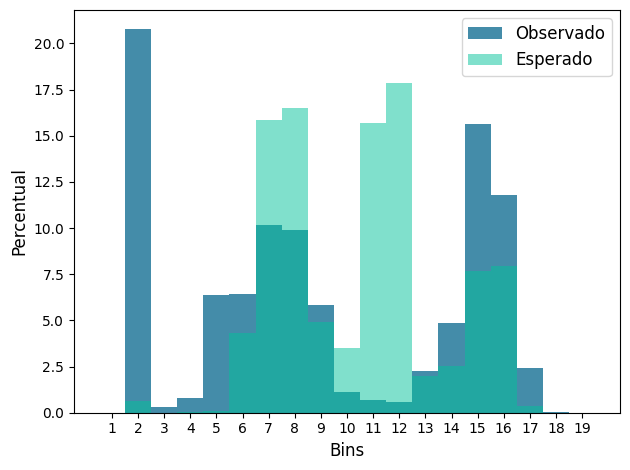

In [115]:
criar_histogramas_ajustados(valor_observado = valor_observado,
                            valor_esperado = valor_esperado,
                            bins = bins,
                            filename = "dataset2_4")

In [116]:
g_test(valor_observado = valor_observado,
       valor_esperado = valor_esperado)

Estatística G: 81.4212158941638
Valor p: 4.8278E-10
Rejeitamos a hipótese nula, há diferença significativa entre os histogramas.


## Extra

### Análise dos dias da semana

O objetivo principal foi analisar se havia algum comportamento interessante ao observar as taxas de *upload* e *download* nos dias da semana. Porém, não foi constatado nenhum fator relevante, sobretudo porque os comportamentos são similares ao longo de toda a semana. De qualquer forma, foram mantidas as análises no presente notebook.

In [117]:
dias_da_semana_dict = {
    "Sunday": "Domingo",
    "Monday": "Segunda",
    "Tuesday": "Terça",
    "Wednesday": "Quarta",
    "Thursday": "Quinta",
    "Friday": "Sexta",
    "Saturday": "Sabado"
}

**Chromecast**

In [118]:
data = pd.to_datetime(df_chromecast['data'], format='%d/%m/%Y')
df_chromecast['dia_da_semana'] = data.dt.day_name()

In [119]:
df_chromecast.replace({"dia_da_semana": dias_da_semana_dict}, inplace = True)

In [120]:
tx_up_chromecast_stats = df_chromecast.groupby("dia_da_semana")["log_taxa_upload"].agg(['mean', 'var', 'std']).reset_index()

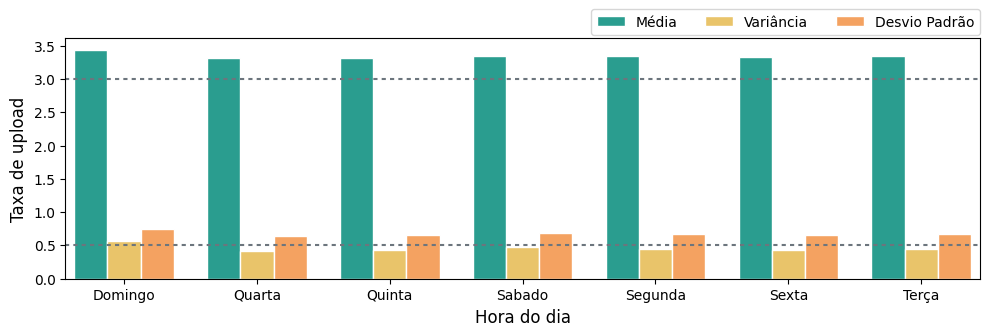

In [121]:
criar_barplots_hora(dataframe = tx_up_chromecast_stats,
                    title_core_name = "taxa de upload",
                    var_interesse = "dia_da_semana",
                    device_name = "chromecast",
                    savefig = False)

In [122]:
tx_dw_chromecast_stats = df_chromecast.groupby("dia_da_semana")["log_taxa_download"].agg(['mean', 'var', 'std']).reset_index()

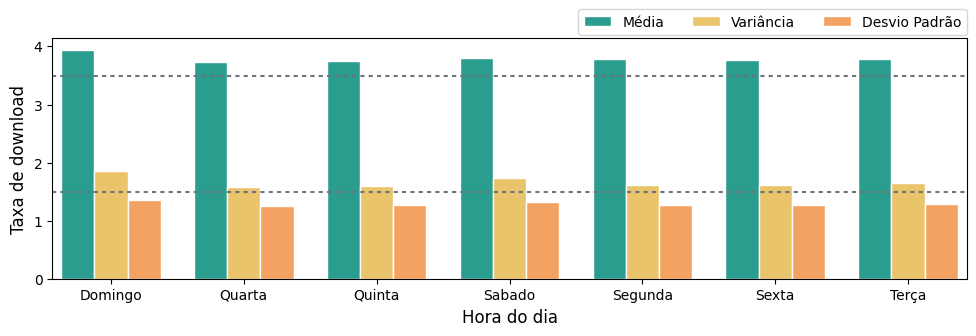

In [130]:
criar_barplots_hora(dataframe = tx_dw_chromecast_stats,
                    title_core_name = "taxa de download",
                    var_interesse = "dia_da_semana",
                    device_name = "chromecast",
                    upline = 3.5,
                    lowline = 1.5,
                    savefig = False)

**Smart TV**

In [124]:
data = pd.to_datetime(df_smart['data'], format='%d/%m/%Y')
df_smart['dia_da_semana'] = data.dt.day_name()

In [125]:
df_smart.replace({"dia_da_semana": dias_da_semana_dict}, inplace = True)

In [126]:
tx_up_smart_stats = df_smart.groupby("dia_da_semana")["log_taxa_upload"].agg(['mean', 'var', 'std']).reset_index()

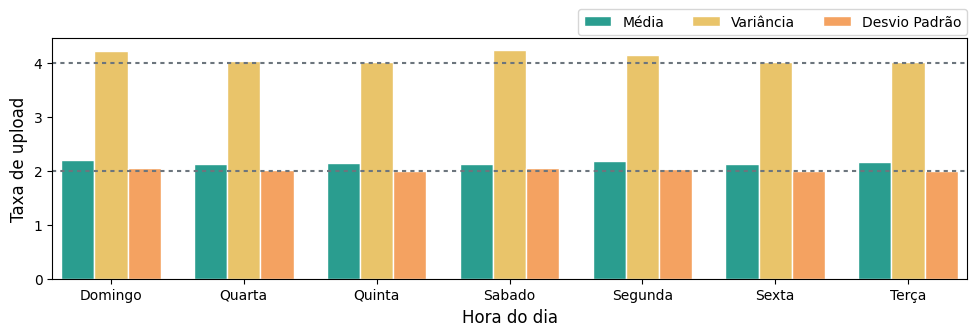

In [131]:
criar_barplots_hora(dataframe = tx_up_smart_stats,
                    title_core_name = "taxa de upload",
                    var_interesse = "dia_da_semana",
                    device_name = "chromecast",
                    upline = 4.0,
                    lowline = 2.0,
                    savefig = False)

In [128]:
tx_dw_smart_stats = df_smart.groupby("dia_da_semana")["log_taxa_download"].agg(['mean', 'var', 'std']).reset_index()

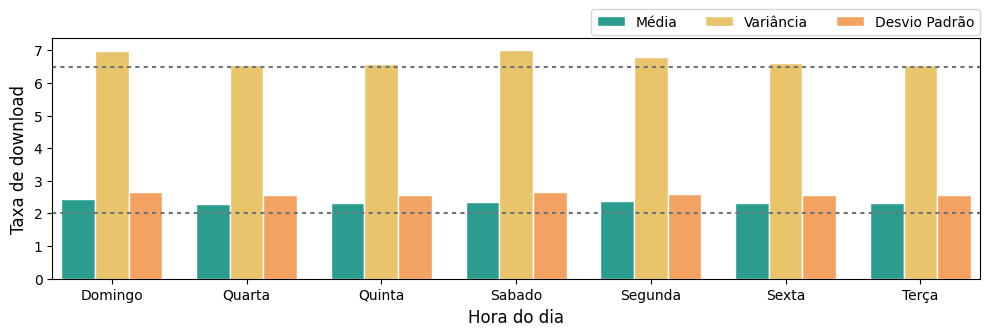

In [132]:
criar_barplots_hora(dataframe = tx_dw_smart_stats,
                    title_core_name = "taxa de download",
                    var_interesse = "dia_da_semana",
                    device_name = "chromecast",
                    upline = 6.5,
                    lowline = 2.0,
                    savefig = False)

**Término do notebook**